<a href="https://colab.research.google.com/github/CamiLopez15/DeepLearning/blob/main/PROYECTO_DEEP_LOPEZ_Y_JARACorte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.BS6WVQ_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.BS6WVQ_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


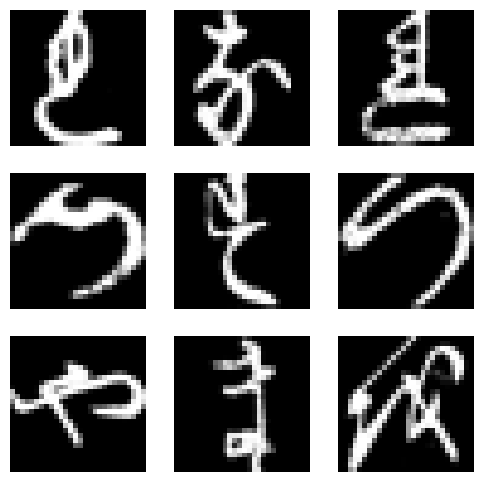

In [ ]:
##María Camila López Muñoz
##Daniel Andrés Jara Martínez

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Cargar el dataset KMNIST desde TensorFlow Datasets
dataset_name = "kmnist"
dataset, info = tfds.load(dataset_name, as_supervised=True, with_info=True)

# Obtener conjuntos de entrenamiento y prueba
train_data, test_data = dataset['train'], dataset['test']
train_data = train_data.shuffle(buffer_size=10000)  # Aleatorización

# Función para visualizar algunas imágenes del dataset
def plot_sample_images(dataset, num_images=9):
    plt.figure(figsize=(6, 6))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()

# Mostrar algunas imágenes de entrenamiento
plot_sample_images(train_data)


In [ ]:
import numpy as np
import tensorflow as tf

# Convertir dataset a numpy arrays para facilitar el preprocesamiento
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Convertir los datos de entrenamiento y prueba a numpy
X_train, y_train = dataset_to_numpy(train_data)
X_test, y_test = dataset_to_numpy(test_data)

# Normalizar los valores de píxeles a un rango de 0 a 1
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Redimensionar para que las imágenes sean vectores de 28x28 (en lugar de matrices 2D)
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Convertir las etiquetas en valores categóricos (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Dividir el conjunto de entrenamiento en entrenamiento (80%) y validación (20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Verificar las dimensiones finales
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (48000, 784), (48000, 10)
Validation set: (12000, 784), (12000, 10)
Test set: (10000, 784), (10000, 10)


In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Función para construir el modelo con hiperparámetros ajustables
def build_model(hp):
    model = Sequential([
        Dense(hp.Choice('units', [128, 256, 512]), activation='relu', input_shape=(784,)),
        Dropout(hp.Choice('dropout', [0.2, 0.3, 0.5])),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

# Definir la búsqueda de hiperparámetros
tuner = kt.RandomSearch(
    build_model,  # Modelo a optimizar
    objective='val_accuracy',  # Objetivo: maximizar la accuracy en validación
    max_trials=5,  # Número de combinaciones a probar
    executions_per_trial=1,  # Número de veces que se ejecuta cada prueba
    directory='hyperparam_search',  # Carpeta donde se guardan los resultados
    project_name='mlp_optimization'
)

# Realizar la búsqueda de hiperparámetros
# The batch_size is now defined as a hyperparameter within the build_model function.
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10,  verbose=1)
                                                                          # Removed batch_size argument
# Obtener los mejores hiperparámetros encontrados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Mostrar los valores óptimos encontrados
print(f"Mejor número de neuronas en la capa oculta: {best_hps.get('units')}")
print(f"Mejor dropout: {best_hps.get('dropout')}")
#print(f"Mejor batch size: {best_hps.get('batch_size')}") #batch size is not a hyperparameter

# Construir el modelo con los mejores hiperparámetros y entrenarlo nuevamente
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=128, verbose=1)
                                                                                      # Set a fixed batch_size

# Evaluar en el conjunto de prueba
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

Reloading Tuner from hyperparam_search/mlp_optimization/tuner0.json
Mejor número de neuronas en la capa oculta: 512
Mejor dropout: 0.3
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7554 - loss: 0.7748 - val_accuracy: 0.9277 - val_loss: 0.2396
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9267 - loss: 0.2397 - val_accuracy: 0.9465 - val_loss: 0.1833
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9521 - loss: 0.1564 - val_accuracy: 0.9534 - val_loss: 0.1565
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9631 - loss: 0.1223 - val_accuracy: 0.9585 - val_loss: 0.1479
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9700 - loss: 0.0976 - val_accuracy: 0.9605 - val_loss: 0.1391
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9749 - loss: 0.0775 - val_accuracy: 0.9605 - val_loss: 0.1392
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9779 - loss: 0.0680 

In [ ]:
# Entrenar el mejor modelo
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    verbose=1
)



Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9905 - loss: 0.0295 - val_accuracy: 0.9668 - val_loss: 0.1704
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9911 - loss: 0.0274 - val_accuracy: 0.9667 - val_loss: 0.1633
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9900 - loss: 0.0295 - val_accuracy: 0.9663 - val_loss: 0.1626
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9913 - loss: 0.0276 - val_accuracy: 0.9655 - val_loss: 0.1744
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9903 - loss: 0.0279 - val_accuracy: 0.9667 - val_loss: 0.1725
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9921 - loss: 0.0242 - val_accuracy: 0.9676 - val_loss: 0.1663
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.9688 - val_loss: 0.1607
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9934 - loss: 0.0201 - val_a

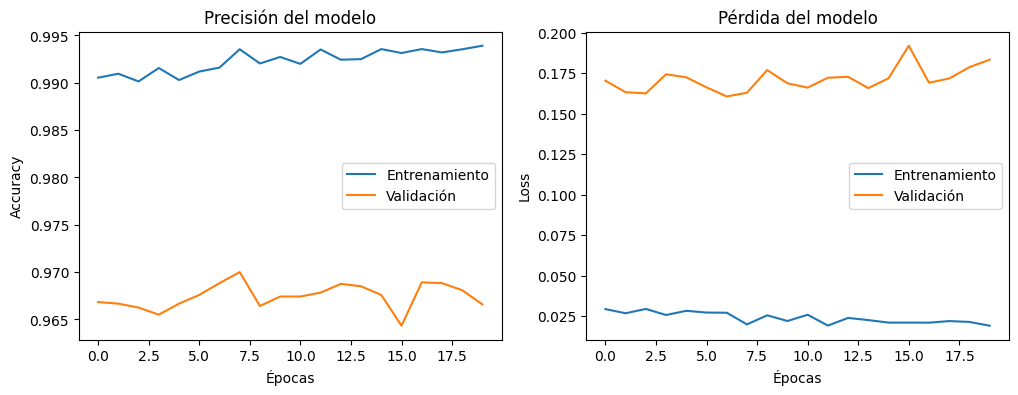

In [ ]:
import matplotlib.pyplot as plt

# Graficar accuracy en entrenamiento y validación
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del modelo')

# Graficar pérdida (loss) en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del modelo')

plt.show()


In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9240 - loss: 0.5221
Precisión en el conjunto de prueba: 0.9218
Pérdida en el conjunto de prueba: 0.5154
